# Processing GEM2 and magnaprobe data - AeN Q1 P4

**Adam Steer**

From Magnaprobe and GEM2 measurements we get snow depth at about 1-2m along track resolotion, and combined snow + ice depth at some unknown resolution.

From these datasets, we need to generate snow depth (done!), ice thickness, draft and freeboard.

For ice thickness, draft and freeboard we rely on some assumptions about hydrostatic equilibrium and density of snow and ice. Using those, we model freeboard and draft using snow depths from the magnaprobe and combined snow and ice thickness from the GEM2 as constraints.

This notebook uses the approach:

- collect drift-corrected magnaprobe data into a set of point geometries
- collect drift-corrected GEM2 data into a set of point geometries
- test each magnaprobe point and find GEM2 data within 2.5 m radius (5m diameter)
- collect the median of GEM2 points found in that radius
- subtract magnaprobe snowdepth from median of GEM2 points
- use median GEM2 data, magnaprobe snow depth, and snow/ice density observations to compute ice thickness, draft and freeboard

This will result in a lot of overlapping data - for example two consecutive magnaprobe points are very likely to have overlap in their region where GEM2 data are collected. Given that GEM2 has a footprint of approximately 4 m diamter, this simple relfects the reality of how the measurements are collected. If needed, spatial filtering can be done later.


In [1]:
## import all the things we need

import os

import numpy as np

from scipy import stats

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['font.size'] =18
inches = 2.51

from shapely import geometry

import pyproj

# array functions, used to generate moving standard deviations
import bottleneck as bn


In [2]:
# declare a function to compute freeboard
def find_fi(zi, zs, dwater, dice, dsnow):
    
    #derived by Claire Trenham, CSIRO, and Adam Steer.
    fi = (((dwater - dice) * zi) - dsnow * zs) / dwater
    
    return fi

# A stats printing function
def printstats(inputdata):
    print("number of observations: {}".format(len(inputdata)))
    print("min: {}".format(np.nanmin(inputdata)))
    print("max: {}".format(np.nanmax(inputdata)))
    print("mean: {}".format(np.nanmean(inputdata)))
    print("median: {}".format(np.nanmedian(inputdata)))
    print("standard deviation: {}".format(np.nanstd(inputdata)))
    print("skewness: {}".format(stats.skew(inputdata)))
    

In [3]:
## set some phsyical properties, these are used to compute sea ice freeboard

# density of seawater
d_water = 1027

# density of sea ice
d_ice = 915

# density of snow
d_snow = 350

### Start loading MP data

In [4]:
mp_data = pd.read_csv("/mnt/documents/Q1/P4-10032021/magnaprobe/MPdata-driftcorrected-datefixed.csv",
                      skiprows = 10)

In [5]:
mp_data

timestamp       easting       northing  snowdepth
0     10-03-2021T07:28:00.85  1.088992e+06 -218643.029725    -0.0001
1     10-03-2021T07:28:03.27  1.088992e+06 -218643.238143     1.2100
2      10-03-2021T07:28:09.6  1.088991e+06 -218642.973287    -0.0001
3     10-03-2021T07:28:16.65  1.088992e+06 -218643.288948     0.2192
4     10-03-2021T07:39:48.78  1.088998e+06 -218645.887661     0.1458
...                      ...           ...            ...        ...
1461  10-03-2021T08:32:15.84  1.088994e+06 -218643.239654     0.2234
1462  10-03-2021T08:32:21.23  1.088994e+06 -218643.528849     1.2100
1463  10-03-2021T08:32:23.07  1.088994e+06 -218643.351429     1.2100
1464  10-03-2021T08:32:24.93  1.088994e+06 -218643.298548     1.2100
1465  10-03-2021T08:58:23.93  1.088998e+06 -218621.219450     0.0010

[1466 rows x 4 columns]

In [6]:
mp_data = mp_data.loc[(mp_data["snowdepth"] > 0) & (mp_data["snowdepth"] < 1.2)]

In [7]:
# generate a list of tuple coordinate pairs
xypairs = list(zip(mp_data["easting"].values, mp_data["northing"].values))

In [8]:
xypairs[0]

(1088992.0386014942, -218643.2889484667)

In [9]:
# make geometries from each point
mp_points = []

for pair in xypairs:
    mp_points.append(geometry.Point(pair[0], pair[1]))

In [10]:
# make buffered points, with 24 sided 'circles'

mp_buffers = []
for point in mp_points:
    mp_buffers.append(point.buffer(2, resolution=36))

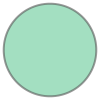

In [11]:
mp_buffers[0]

### Check distance between magnaprobe samples

get difference between array elements in X and Y coordinates, do some Pythagoras to get an idea of the magnaprobe observation step size.

This gives an approximate along-track ground sampling distance, useful for setting filtering windows later

In [12]:
stepX = np.diff(mp_data["easting"].values-5)
stepY = np.diff(mp_data["northing"].values)
mp_point2point = np.sqrt(stepX**2 + stepY**2)

In [13]:
printstats(mp_point2point)

number of observations: 1459
min: 0.010426111443965434
max: 22.339982982134263
mean: 0.9416886201860989
median: 0.8390049912575043
standard deviation: 0.8243776469361107
skewness: 13.736635009257595


### Read and geometry-ify GEM2 data

In [14]:
gem2_data = pd.read_csv("/mnt/documents/Q1/P4-10032021/GEM2/GEM2data-driftcorrected.csv",
                      skiprows = 10)

In [15]:
gem2_data[0:5]

time   record_id       easting       northing   xc  \
0  2021-11-03T07:37:36.515625           3  1.088994e+06 -218642.016960  0.0   
1  2021-11-03T07:37:36.617187           4  1.088994e+06 -218642.016395  0.0   
2  2021-11-03T07:37:36.710937           5  1.088994e+06 -218642.018219  0.0   
3  2021-11-03T07:37:36.812500           6  1.088994e+06 -218642.017654  0.0   
4  2021-11-03T07:37:36.914062           7  1.088994e+06 -218642.018990  0.0   

    yc  f450Hz_hcp_i   f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
0  0.0         0.831          0.771           0.766           0.757   
1  0.0         0.751          0.727           0.735           0.759   
2  0.0         0.695          0.722           0.737           0.754   
3  0.0         0.674          0.750           0.766           0.749   
4  0.0         0.682          0.766           0.751           0.739   

    f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i   f18330Hz_hcp_q  \
0           0.773           0.748            0.763            0.739   
1           0.766           0.748            0.764            0.738   
2           0.771           0.751            0.762            0.738   
3           0.770           0.756            0.764            0.738   
4           0.765           0.753            0.765            0.738   

    f63030Hz_hcp_i  f63030Hz_hcp_q  
0            0.756             nan  
1            0.755             nan  
2            0.755             nan  
3            0.755             nan  
4            0.755             nan

In [16]:
gem2_data.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

### check distance between GEM2 samples

This gives an approximate along-track ground sampling distance, useful for setting filtering windows later

In [17]:
stepX = np.diff(gem2_data["easting"].values)
stepY = np.diff(gem2_data["northing"].values)

gem2_point2point = np.sqrt(stepX**2 + stepY**2)

In [18]:
printstats(gem2_point2point)

number of observations: 23261
min: 0.00022177663431501718
max: 0.23470311009990927
mean: 0.044435032459470225
median: 0.05606957451661433
standard deviation: 0.02771691075733068
skewness: -0.4807288012117911


### Check that the coordinates line up!

Added a -5m translation to Magnaprobe data eastings so it lines up. Northing seems OK

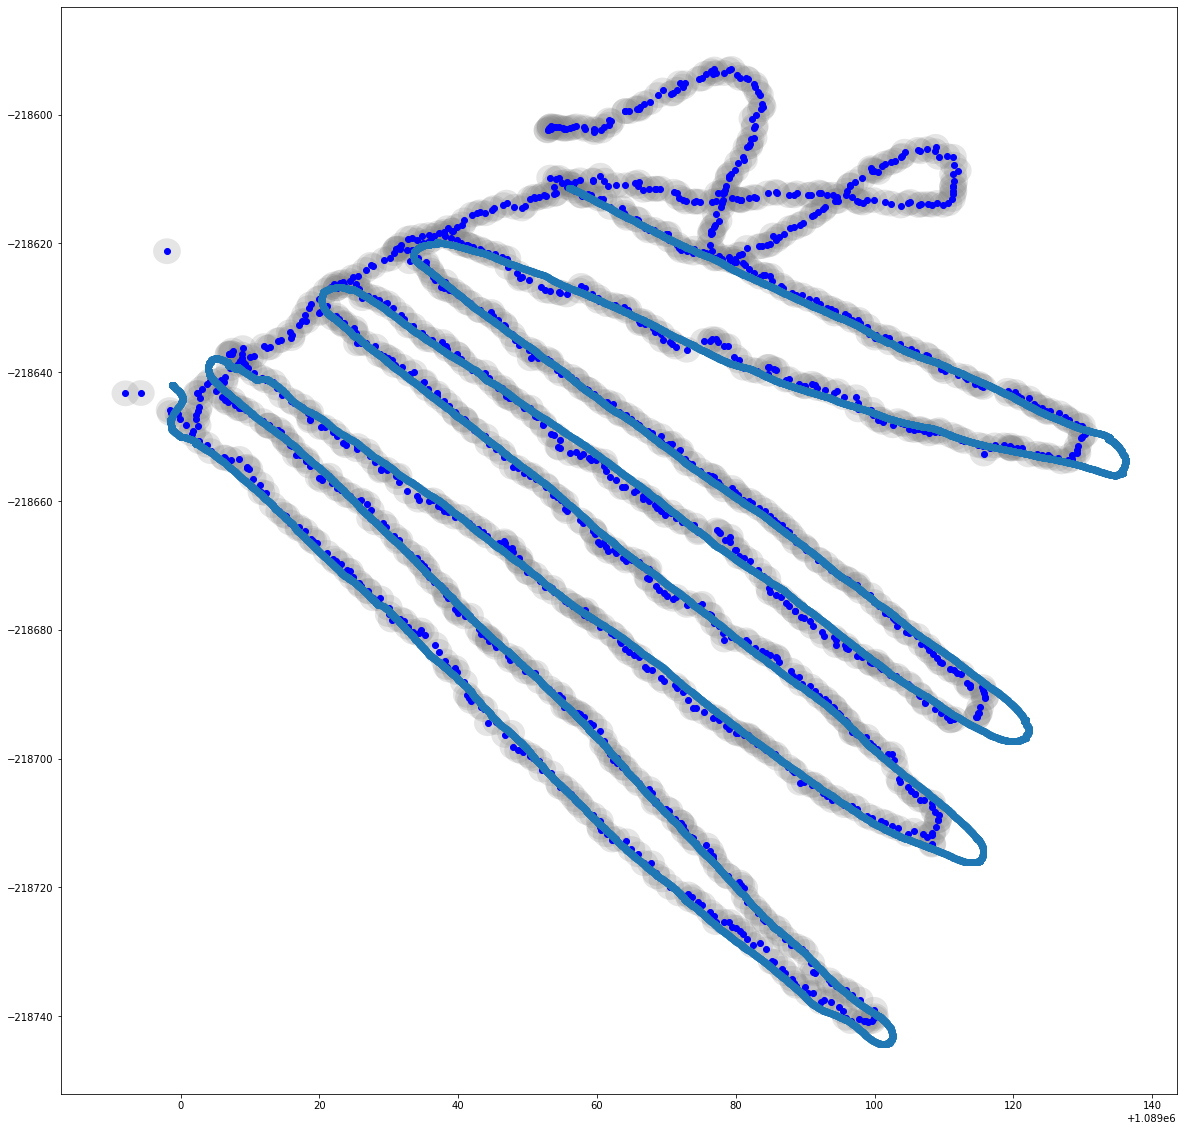

In [19]:
fig = plt.figure(figsize=(20,20))

for dot in mp_buffers:    
    xs, ys = dot.boundary.xy    
    plt.fill(xs, ys, alpha=0.2, fc='grey', ec='none')
    
plt.scatter(mp_data["easting"].values, mp_data["northing"].values, c="Blue")
plt.scatter(gem2_data["easting"].values+5, gem2_data["northing"].values)

In [20]:
len(gem2_data["easting"].values)

23262

In [21]:
gem2_xypairs = list(zip(gem2_data["easting"].values+5, gem2_data["northing"].values))

In [22]:
# make geometries from each point
gem2_points = []

for pair in gem2_xypairs:
    gem2_points.append(geometry.Point(pair[0], pair[1]))

In [23]:
len(gem2_points)

23262

## Select GEM2 data points to use

- find GEM2 points within the buffer from MP points
- collect GEM2 observations matching those points
- compute the median of GEM2 observations
- assemble an array of MP and matching median GEM2 observations

In [24]:
mp_ind = 0
gem2_ind = 0
bufferpoints = []
collected_points = []

# iterate over MP buffers
for buffer in mp_buffers:
    #print("buffer {}".format(mp_ind))
    #then over gem2 points
    for thispoint in gem2_points:
        
        #if the buffer contains the point
        if buffer.contains(thispoint):
            
            #capture the index of each point the buffer contains
            bufferpoints.append(gem2_ind)
        
        gem2_ind += 1
    gem2_ind = 0
    collected_points.append([mp_ind, bufferpoints])
    bufferpoints = []
    mp_ind += 1

In [26]:
gem2_data[" f5310Hz_hcp_i"][np.array(collected_points[4][1])]

360    0.749
361    0.749
362    0.755
363    0.750
364    0.757
       ...  
459    0.771
460    0.788
461    0.785
462    0.791
463    0.798
Name:  f5310Hz_hcp_i, Length: 104, dtype: float64

In [27]:
np.median(gem2_data[" f5310Hz_hcp_i"][np.array(collected_points[4][1])])

0.813

In [28]:
# f5310Hz_hcp_q

np.median(gem2_data[" f1530Hz_hcp_i"][np.array(collected_points[4][1])])


0.797

In [29]:
#generate a list of MP data indexes and GEM2 median measurements
median_gem2 = []

for datapoint in collected_points:
    if len(datapoint[1]) > 0:
        thismedian = np.median(gem2_data[" f5310Hz_hcp_i"][datapoint[1]])

    else:
        thismedian = np.nan
        
    the_array = [datapoint[0], thismedian]
    median_gem2.append(the_array)

In [30]:
median_gem2[0:5]

[[0, nan], [1, 0.82], [2, 0.819], [3, 0.8174999999999999], [4, 0.813]]

In [31]:
mp_inds = [pair[0] for pair in median_gem2]
mp_inds[0:5]

[0, 1, 2, 3, 4]

In [32]:
gem2_zi = [pair[1] for pair in median_gem2]

In [33]:
len(mp_inds)

1460

In [34]:
len(mp_data["snowdepth"])

1460

In [35]:
zi = gem2_zi - mp_data["snowdepth"].values

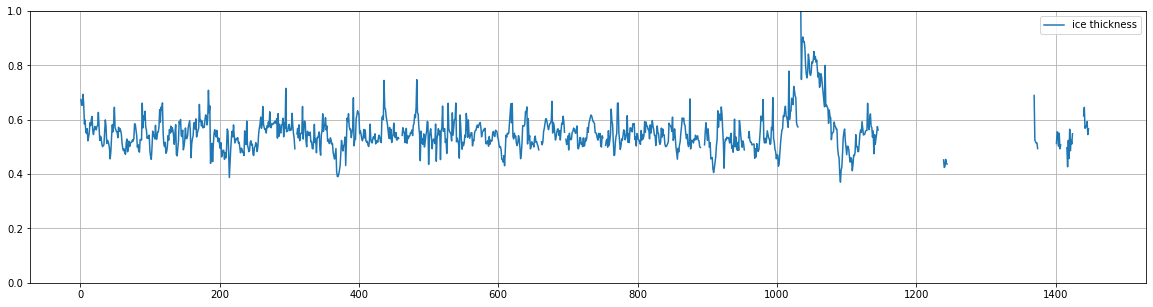

In [36]:
# quick ice thickness plot.
# note any negative values likely come from a data point in the Magnaprobe dataset which should be cleaned out 

fig = plt.figure(figsize=(20,5))

plt.plot(zi, label = "ice thickness")
plt.ylim(0, 1)
plt.legend()
plt.grid()

In [37]:
# show some basic stats
printstats(zi[5:-5])

number of observations: 1450
min: 0.37040000000000006
max: 1.0844600000000002
mean: 0.5515710069444445
median: 0.5425
standard deviation: 0.06961481033700297
skewness: nan


#### Ice freeboard

In [38]:
#(zi, zs, dwater, dice, dsnow)
freeboards = find_fi(zi,mp_data["snowdepth"].values, 1027, 915, 315)

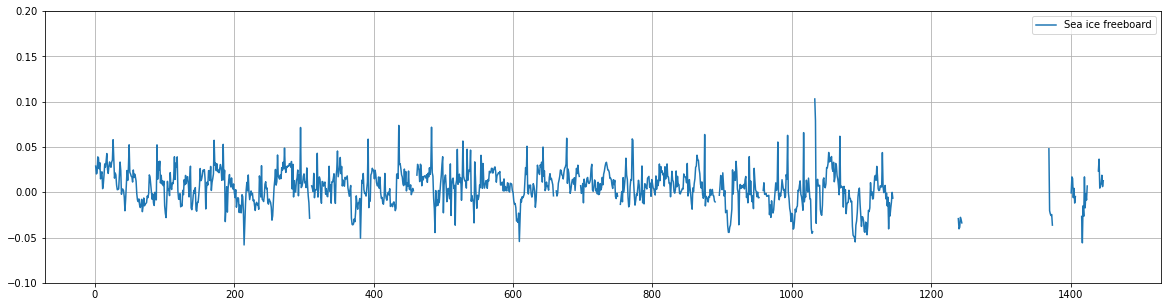

In [39]:
fig = plt.figure(figsize=(20,5))

plt.plot(freeboards, label = "Sea ice freeboard")
plt.ylim(-0.1, 0.2)
plt.legend()
plt.grid()

In [40]:
printstats(freeboards)

number of observations: 1460
min: -0.05823291139240507
max: 0.10291813047711788
mean: 0.005693226783500629
median: 0.006449269717624152
standard deviation: 0.01944029104740198
skewness: nan


### ice draft

In [41]:
drafts = freeboards - zi

(-1.0, 0.0)

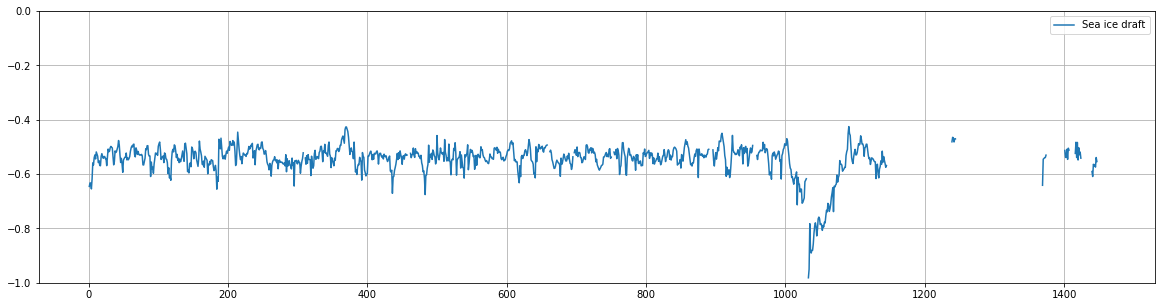

In [42]:
fig = plt.figure(figsize=(20,5))

plt.plot(drafts, label = "Sea ice draft")
plt.legend()
plt.grid()
plt.ylim(-1,0)

In [43]:
printstats(drafts)

number of observations: 1460
min: -0.9815418695228824
max: -0.42527263875365146
mean: -0.546280239076482
median: -0.53595423563778
standard deviation: 0.05841942051517914
skewness: nan


#### Sea ice surface elevation

What we see at the top - snow depth plus freeboard

In [44]:
elevation = freeboards + mp_data["snowdepth"].values

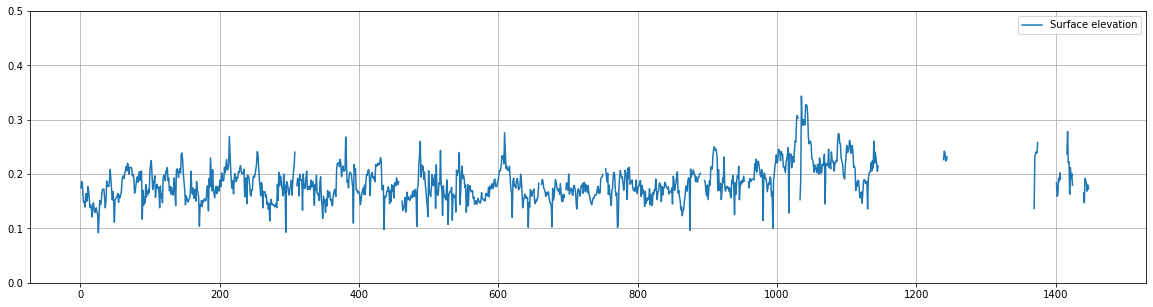

In [45]:
fig = plt.figure(figsize=(20,5))

plt.plot(elevation, label = "Surface elevation")
plt.ylim(0, 0.5)
plt.legend()
plt.grid()

#### snowdepth

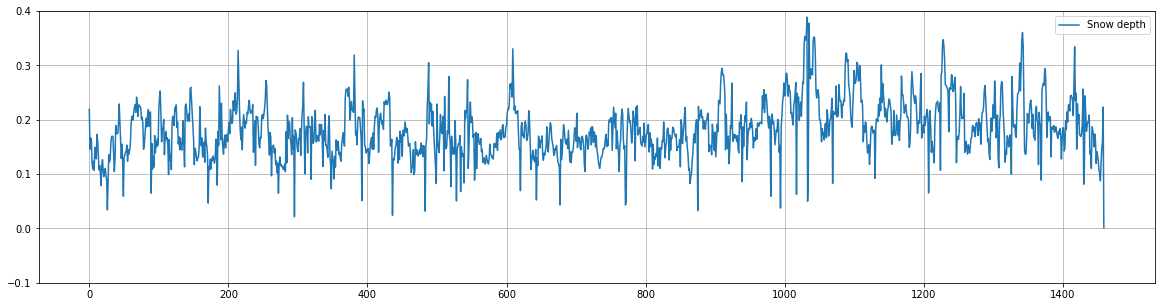

In [46]:
fig = plt.figure(figsize=(20,5))

plt.plot(mp_data["snowdepth"].values,label = "Snow depth")
plt.ylim(-0.1, 0.4)
plt.legend()
plt.grid()

In [47]:
printstats(mp_data["snowdepth"].values)

number of observations: 1460
min: 0.001
max: 0.3887
mean: 0.18150187671232876
median: 0.17695
standard deviation: 0.050793685843286106
skewness: 0.40179373586627587


### Estimate surface and under-ice roughness

Collect a proxy for roughness - the standard deviation of elevation (and draft) within an approximate 5 m sliding window

In [48]:
## surface roughness. Because step size is about 0.8m, we use a window size of 6 - approx. 4.m along track

elevation_roughness = bn.move_std(elevation, window=6)


In [49]:
## draft roughness, same window size

draft_roughness = bn.move_std(drafts, window=6)

## Plot all the things together

AttributeError: module 'matplotlib.pyplot' has no attribute 'grd'

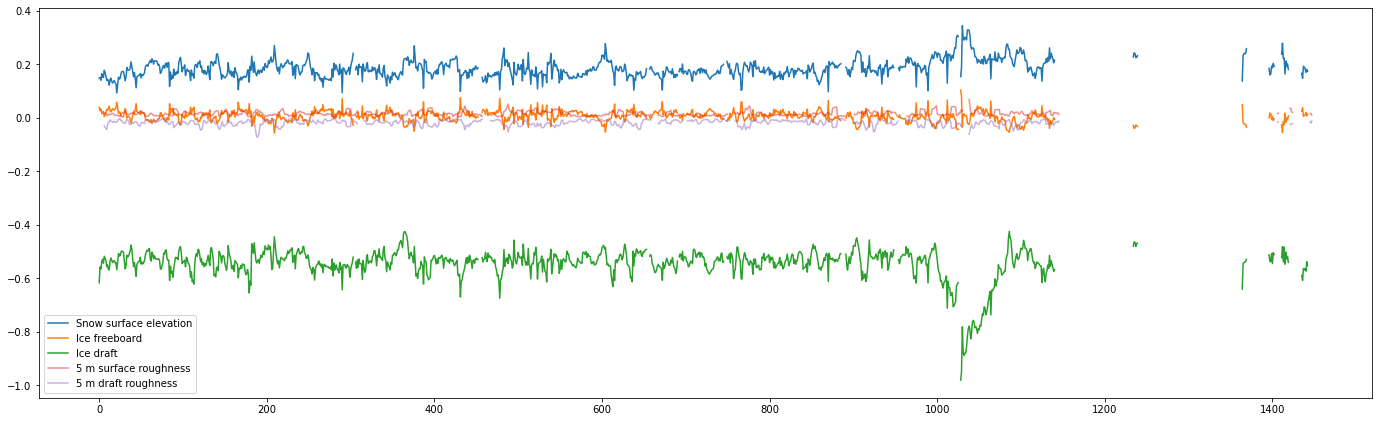

In [50]:
fig = plt.figure(figsize=(60/inches,18/inches))

plt.plot(freeboards[5:-5] + mp_data["snowdepth"].values[5:-5], label = "Snow surface elevation")
plt.plot(freeboards[5:-5], label = "Ice freeboard")
plt.plot(drafts[5:-5], label = "Ice draft")

## roughnesses are offset a little, just so they're visible
plt.plot(np.array(elevation_roughness), label = "5 m surface roughness", alpha = 0.5)

plt.plot((0-draft_roughness), label = "5 m draft roughness", alpha = 0.5)


plt.legend()

plt.grd()
ax = plt.gca()

thenumbers = np.arange(0, len(drafts),250)
xticks_meters = [x * np.median(mp_point2point) for x in thenumbers]

plt.xticks(thenumbers,xticks_meters)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_xlabel("Meters along track (approximate)")
ax.set_ylabel("Height relative to sea level (meters)")

plt.savefig("/mnt/documents/Q1/P4-10032021/alongtrack-snowandice.png")


In [ ]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [ ]:
fig = plt.figure(figsize=(10,10))

mapproj = ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 )

ax = plt.axes(projection= mapproj)


plt.scatter(mp_data["easting"].values-5, mp_data["northing"].values, c=zi,
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ))
#cbar = plt.colorbar()
#cbar.set_label("Ice thickness")
#gl = ax.gridlines(draw_labels=True)
#gl.top_labels = False
#gl.right_labels = False

showgridlines = ax.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True, x_inline = False)


In [ ]:
icebins = np.arange(0, np.nanmax(zi[5:-5]), 0.05)
snowbins = np.arange(0, 0.5, 0.005)

In [ ]:
fig = plt.figure(figsize = (30/inches,15/inches))

ax1 = fig.add_subplot(121)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(zi, icebins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = 'ice thickness',
                            density = True)


day1snowhist, snowx, _ = ax2.hist(mp_data["snowdepth"].values, snowbins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = 'snow depth', density = True)


ax1.set_xlabel("Ice thickness (meters)")
ax1.set_ylabel("Probability density")
ax2.set_xlabel("Snow depth (meters)")

plt.savefig("/mnt/documents/Q1/P4-10032021/AeNQ1-2021-P6-zi-zs-2panelhistogram.png")

In [ ]:
fig = plt.figure(figsize = (15/inches,15/inches))

ax1 = fig.add_subplot(111)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(zi[5:-5], icebins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = 'Ice thickness',
                             density = True)


day1snowhist, snowx, _ = ax1.hist(mp_data["snowdepth"].values, snowbins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = 'Snow depth', density = True)


#ax1.set_xlabel("GEM2 ice thickness (meters)")
ax1.set_ylabel("Probability density")
#ax2.set_xlabel("Magnaprobe snow depth (meters)")

plt.legend()

plt.savefig("/mnt/documents/Q1/P4-10032021/AeNQ1-2021-P4-zi-zs-onepanelhistogram.png")
plt.ylim(0,10)

In [ ]:
fb_bins = np.arange(0, np.nanmax(freeboards), 0.005)
elevbins = np.arange(0, 1, 0.01)

In [ ]:
fig = plt.figure(figsize = (16,6))

ax1 = fig.add_subplot(121)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(freeboards, fb_bins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = 'Freeboard')


day1snowhist, snowx, _ = ax2.hist(elevation, elevbins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = 'Elevation')


ax1.set_xlabel("Ice freeboard")
ax1.set_ylabel("Number of observations")
ax2.set_xlabel("Elevation")

In [ ]:
elev_roughness_bins = np.arange(0, np.nanmax(elevation_roughness), 0.005)
draft_roughness_bins = np.arange(0, np.nanmax(draft_roughness), 0.005)


In [ ]:
fig = plt.figure(figsize = (16,6))

ax1 = fig.add_subplot(121)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(elevation_roughness, elev_roughness_bins, 
                             density = True,
                             linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = '5 m surface roughness')


day1snowhist, snowx, _ = ax2.hist(draft_roughness, draft_roughness_bins,
                                density = True,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = '5 m draft roughness')


ax1.set_xlabel("Surface roughness")
ax1.set_ylabel("Probability density")
ax2.set_xlabel("Draft roughness")

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.scatter(zi, elevation)
plt.xlim(0, 1)
plt.ylim(0, 0.5)
plt.grid()
plt.xlabel("ice thickness")
plt.ylabel("surface elevation")


In [ ]:
# from: https://localcoder.org/pearson-correlation-and-nan-values

bad = ~np.logical_or(np.isnan(elevation), np.isnan(zi))

elevs_for_r = np.compress(bad, elevation)
zi_for_r = np.compress(bad, zi)

In [ ]:
stats.spearmanr(elevation, zi, nan_policy = "omit")

## Some main core site stats

In [ ]:
maincore = pd.read_csv("/mnt/documents/Q1/P4-10032021/Q1-P4_ICETEAM-NOTES_20210310_MM.csv", skiprows=5)

In [ ]:
maincore[0:2]

In [ ]:
snow1 = []
for x in maincore["snow depth 1 (cm)"]:
    try:
        snow1.append(float(x))
    except:
        pass
    

for x in maincore["snow depth 2 (cm)"]:
    try:
        snow1.append(float(x))
    except:
        pass
    
for x in maincore["snow depth 3 (cm)"]:
    try:
        snow1.append(float(x))
    except:
        pass

## map of ice thickness values

Visualising how many matches we got between MP and GEM2 data

In [ ]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [ ]:
fig = plt.figure(figsize=(15,15))

mapproj = ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 )

ax = plt.axes(projection= mapproj)


plt.scatter(mp_data["easting"].values, mp_data["northing"].values, c=zi, s = (zi)**4,
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ),
           label = "Ice thickness", cmap="Blues")

plt.scatter(mp_data["easting"].values, mp_data["northing"].values,
           c=elevation, s = (5 * elevation)**4, cmap="viridis",
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ),
           label = "Ice thickness")


plt.scatter(mp_data["easting"].values, mp_data["northing"].values,
           c=mp_data["snowdepth"].values, s = (10*mp_data["snowdepth"].values), cmap="Greys",
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ),
           label = "Ice thickness")
#cbar = plt.colorbar()
#cbar.set_label("Ice thickness")
#gl = ax.gridlines(draw_labels=True)
#gl.top_labels = False
#gl.right_labels = False

showgridlines = ax.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True, x_inline = False)


In [ ]:
fig = plt.figure(figsize=(10,10))

mapproj = ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 )

ax = plt.axes(projection= mapproj)


plt.scatter(mp_data["easting"].values[1:], mp_data["northing"].values[1:], c= mp_point2point, s= mp_point2point**4, alpha=0.5,
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ))
#cbar = plt.colorbar()
#cbar.set_label("Ice thickness")
#gl = ax.gridlines(draw_labels=True)
#gl.top_labels = False
#gl.right_labels = False

showgridlines = ax.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True, x_inline = False)

## Export ice thickness data to a CSV file

In [ ]:
backtolatlon = pyproj.transformer.Transformer.from_proj(3413,4326)
latlon = backtolatlon.transform( mp_data["northing"].values,mp_data["easting"].values,)

In [ ]:
zi_export = pd.DataFrame({"timestamp": mp_data["timestamp"].values,
                          "easting": mp_data["easting"].values,
                          "northing": mp_data["northing"].values,
                          "latitude": latlon[0],
                          "longitude": latlon[1],
                          "snowdepth": mp_data["snowdepth"].values,
                          "ice_freeboard": freeboards,
                          "ice_thickness": zi,
                          "surface_elevation": elevation,
                          "ice_draft": drafts,
                          "5m_surface_roughness": elevation_roughness,
                          "5m_draft_roughness": draft_roughness})

In [ ]:
header = """
Snow depth and ice thickness data from AeN Q1, P4
March 2021
Adam Steer, Dmitry Divine

GEM2 data described here: [link to data file]
GEM2 data processed using libraries supplied by Stefan Hendricks: 

Magnaprobe data are described here: [link to data fele]

Drift correction and data alignment is described here: [link to notebook]
Units are meters
Eastings and northings are EPSG:3413, NSIDC north polar stereographic


"""

In [ ]:
outputfile = "/mnt/documents/Q1/P4-10032021/AenQ1-P4-snowandice.csv"

In [ ]:
with open(outputfile, 'w') as outfile:
    outfile.write(header)
    
zi_export.to_csv(outputfile, index=False, mode='a')